In [1]:
from numba.pycc import CC
from photon import *
import numpy as np
from numba import typed, types
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from plot import *
from numpy import genfromtxt
from numba.cuda.random import init_xoroshiro128p_states
from mpl_toolkits.mplot3d import Axes3D
import os
from matplotlib import cm
from scipy import optimize
from tqdm.notebook import trange, tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

def fit_func(x, const, a, b, c, d):
    return np.power(x, 3) * d + np.power(x, 2) * c + np.power(x, 2) * b + x * a + const


gridDim = 1
blockDim = 128
dim = gridDim * blockDim
all_adj_dist = []
all_collected = []
all_amps = []
all_modes = []
mode = 1.0
iters = 3 * 16
iters =512
NNxy = 500
NNr = int(NNxy/2)
NNz = int(NNxy/2)
degree_divs = 64
n_steps=100

np.random.seed(1)
s1 = genfromtxt(f's1_pm_{degree_divs}.txt', delimiter=',')
s2 = genfromtxt(f's2_pm_{degree_divs}.txt', delimiter=',')
m11 = genfromtxt(f'm11_pm_{degree_divs}.txt', delimiter=',')
m12 = genfromtxt(f'm12_pm_{degree_divs}.txt', delimiter=',')
temp = 1j * s1[:, 2]
temp += s1[:, 1]
s1 = temp
temp = 1j * s2[:, 2]
temp += s2[:, 1]
s2 = temp
m11 = m11[:, 1]
m12 = m12[:, 1]

s1 = np.ascontiguousarray(s1)
s2 = np.ascontiguousarray(s2)
m11 = np.ascontiguousarray(m11)
m12 = np.ascontiguousarray(m12)
cuda.pinned(s1)
cuda.pinned(s2)
cuda.pinned(m11)
cuda.pinned(m12)

co_xy_all = np.zeros((dim, NNxy, NNxy), dtype=np.float32)
co_rz_all = np.zeros((dim, NNr, NNz), dtype=np.float32)
co_rz_trad_all = np.zeros((dim, NNr, NNz), dtype=np.float32)
incoh_cross_xy_all=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
incoh_cross_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
cross_xy_all=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
cross_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
i_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
q_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
u_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
v_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)

ctr = 0
ctr_trad = 0
ctr_cross=0
# os.environ['NUMBA_DEBUG']='1'
# print(cuda.gpus)
# polarization mode 0):nonpolarized 1:p-polarized 2:s-polarized
for i in trange(iters, desc='1st loop'):
    mode = i % 3
    mode =3
    random_nums=np.random.rand(dim, n_steps * 10)
    d_amplitudes =        cuda.to_device(np.ones(dim, dtype=np.float32))
    d_steps =             cuda.to_device(np.zeros(dim, dtype=np.float32))
    d_lengths =           cuda.to_device(np.zeros(dim, dtype=np.float32))
    d_direction_theta =   cuda.to_device(np.ones(dim, dtype=np.float32) * (np.pi / 2))
    d_maxZs =             cuda.to_device(np.zeros(dim, dtype=np.float32))
    d_position_x =        cuda.to_device(np.zeros(dim, dtype=np.float32))
    d_position_y =        cuda.to_device(np.ones(dim, dtype=np.float32) * (1e-8))
    d_polarization =      cuda.to_device(np.ones(dim, dtype=np.float32))
    d_adjusted_dist =     cuda.to_device(np.zeros(dim, dtype=np.float32))
    d_collected =         cuda.to_device(np.zeros(dim, dtype=np.float32))
    d_modes =             cuda.to_device(np.ones(dim, dtype=np.float32) * mode)

    d_jones =             cuda.to_device(np.zeros((dim, 4), dtype=np.complex64))
    d_jones_partial =     cuda.to_device(np.zeros((dim, 4), dtype=np.complex64))
    d_U =                 cuda.to_device(np.zeros((dim, 3), dtype=np.float32))
    d_W =                 cuda.to_device(np.zeros(dim, dtype=np.float32))
    d_mu_as =             cuda.to_device(np.ones(dim, dtype=np.float32) * 0)
    d_mu_ss =             cuda.to_device(np.ones(dim, dtype=np.float32) * np.float(100))
    d_scat_events =       cuda.to_device(np.zeros(dim, dtype=np.float32))
    d_co_xy =             cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
    d_cross_xy =          cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
    d_incoh_cross_xy =    cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
    d_co_rz =             cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_cross_rz =          cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_incoh_cross_rz =    cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_co_xy_trad =        cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
    d_cross_xy_trad =     cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
    d_incoh_cross_xy_trad=cuda.to_device(np.zeros((dim, NNxy, NNxy), dtype=np.float32))
    d_co_rz_trad =        cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_cross_rz_trad =     cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_incoh_cross_rz_trad=cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_position =          cuda.to_device(np.zeros((NNxy, 3), dtype=np.float32))
    d_i_stokes_rz=        cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_q_stokes_rz =       cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_u_stokes_rz =       cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_v_stokes_rz =       cuda.to_device(np.zeros((dim, NNr, NNz), dtype=np.float32))
    d_random_nums =       cuda.to_device(random_nums)
    # rng_states = create_xoroshiro128p_states(dim, seed=1)
    rng_states=1
    seed = i
    # print(rng_states)
    # rng_states = init_xoroshiro128p_states(gridDim * blockDim + i + int(mode), seed=int(mode + 1 + i))

    process_steps[gridDim, blockDim](seed, d_amplitudes, d_direction_theta, d_position_x, d_position_y, d_polarization, d_steps,
                                     d_lengths, d_maxZs, rng_states, d_adjusted_dist, d_collected, d_modes,d_random_nums, d_U, d_W, d_jones, d_mu_as,
                                     d_mu_ss,
                                     d_scat_events, d_jones_partial, d_co_xy, d_cross_xy, d_incoh_cross_xy, d_co_rz, d_cross_rz,
                                     d_incoh_cross_rz,
                                     d_co_xy_trad, d_cross_xy_trad, d_incoh_cross_xy_trad, d_co_rz_trad, d_cross_rz_trad,
                                     d_incoh_cross_rz_trad, d_position, s1, s2, m11, m12,d_i_stokes_rz,d_q_stokes_rz,d_u_stokes_rz,d_v_stokes_rz)
    # nb.cuda.profile_stop()

    #amplitudes=d_amplitudes.copy_to_host()
    # d_steps.copy_to_host()
    # d_lengths.copy_to_host()
    # d_direction_theta.copy_to_host()
    # d_maxZs.copy_to_host()
    # d_position_x.copy_to_host()
    # d_position_y.copy_to_host()
    # d_polarization.copy_to_host()
    # d_adjusted_dist.copy_to_host()
    # d_collected.copy_to_host()
    # d_modes.copy_to_host()
    # d_jones.copy_to_host()
    # d_jones_partial.copy_to_host()
    # d_U.copy_to_host()
    # d_W.copy_to_host()
    # d_mu_as.copy_to_host()
    # d_mu_ss.copy_to_host()
    # d_scat_events.copy_to_host()
    co_xy=d_co_xy.copy_to_host()
    cross_xy=d_cross_xy.copy_to_host()
    incoh_cross_xy=d_incoh_cross_xy.copy_to_host()
    co_rz=d_co_rz.copy_to_host()
    cross_rz=d_cross_rz.copy_to_host()
    incoh_cross_rz=d_incoh_cross_rz.copy_to_host()
    co_xy_trad=d_co_xy_trad.copy_to_host()
    cross_xy_trad=d_cross_xy_trad.copy_to_host()
    incoh_cross_xy_trad=d_incoh_cross_xy_trad.copy_to_host()
    co_rz_trad=d_co_rz_trad.copy_to_host()
    cross_rz_trad=d_cross_rz_trad.copy_to_host()
    incoh_cross_rz_trad=d_incoh_cross_rz_trad.copy_to_host()
    position=d_position.copy_to_host()
    i_stokes_rz = d_i_stokes_rz.copy_to_host()
    q_stokes_rz = d_q_stokes_rz.copy_to_host()
    u_stokes_rz = d_u_stokes_rz.copy_to_host()
    v_stokes_rz = d_v_stokes_rz.copy_to_host()
    # nb.cuda.profile_stop()

    # all_adj_dist.append(adjusted_dist)
    # all_collected.append(collected)
    # all_amps.append(amplitudes)
    # all_modes.append(modes)
    
    i_stokes_rz_all+=i_stokes_rz
    q_stokes_rz_all+=q_stokes_rz
    u_stokes_rz_all+=u_stokes_rz
    v_stokes_rz_all+=v_stokes_rz
    
    if not(np.isnan(co_rz.max())):
        co_rz_all += co_rz
        co_xy_all += co_xy  
        
        ctr+=1
        print(ctr, 'partial',co_rz.max())
    if not(np.isnan(co_rz_trad.max())):
        co_rz_trad_all+=co_rz_trad
        ctr_trad+=1
        print(ctr_trad, 'trad',co_rz_trad.max())
        
    if not (np.isnan(incoh_cross_xy_all.max())):
        incoh_cross_xy_all+=incoh_cross_xy        
        
        incoh_cross_rz_all+=incoh_cross_rz      
        ctr_cross+=1
    if not (np.isnan(cross_xy_all.max())):
        cross_xy_all+=cross_xy
        cross_rz_all+=cross_rz

1 partial 637.8706
1 trad 0.0
2 partial 629.97424
2 trad 0.0
3 partial 631.78754
3 trad 0.0
4 partial 636.66144
4 trad 0.0
5 partial 640.05817
5 trad 0.0
6 partial 630.83
6 trad 0.0
7 partial 631.4058
7 trad 0.0
8 partial 633.5985
8 trad 0.0
9 partial 629.37836
9 trad 0.0
10 partial 641.3757
10 trad 0.0
11 partial 634.1077
11 trad 0.0
12 partial 637.503
12 trad 0.0
13 partial 636.57684
13 trad 0.0
14 partial 634.65533
14 trad 0.0
15 partial 635.286
15 trad 0.0
16 partial 638.10846
16 trad 0.0
17 partial 625.0672
17 trad 0.0
18 partial 640.03723
18 trad 0.0
19 partial 638.7337
19 trad 0.0
20 partial 637.5927
20 trad 0.0
21 partial 635.24524
21 trad 0.0
22 partial 641.4029
22 trad 0.0
23 partial 638.4091
23 trad 0.0
24 partial 639.4132
24 trad 0.0
25 partial 637.97565
25 trad 0.0
26 partial 641.6661
26 trad 0.0
27 partial 634.3508
27 trad 0.0
28 partial 637.57587
28 trad 0.0
29 partial 639.17804
29 trad 0.0
30 partial 617.4713
30 trad 0.0
31 partial 641.01917
31 trad 0.0
32 partial 641.1

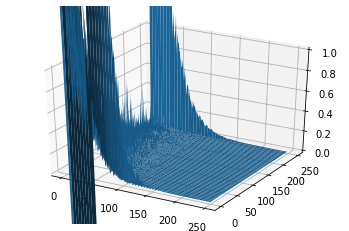

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%load_ext autoreload
%autoreload 2

co_rz_all=co_rz_linear
# co_rz_all[np.isnan(co_rz_all)]=0
ctr=512
grid_size = NNr
x = np.sum(co_rz_all, axis=0)
#print(np.unique(co_rz_all))
x[0,0]=0
x[grid_size-1,grid_size-1]=0
# mean = np.mean(x)
# std = np.std(x)
# x = (x - mean) / std
x/=ctr
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(range(grid_size), range(grid_size))  # `plot_surface` expects `x` and `y` data to be 2D
ax.plot_surface(X, Y, x)
ax.set_zlim(0, 1)
plt.show()

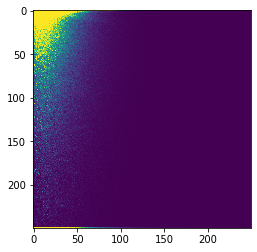

In [7]:
import scipy.misc

x_clipped=x/x.max()
x_clipped=np.clip(x,0,1)
plt.imshow(x_clipped)
plt.savefig('co_linear_4m.png')
# scipy.misc.imsave('outfile.jpg', image_array)
plt.show()

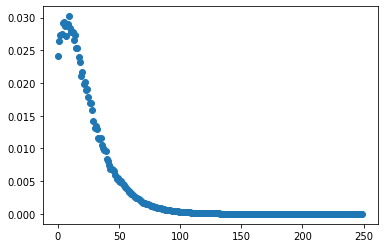

In [64]:
from scipy import optimize
def fit_func(x, const, a, b, c,d,e):
    return np.power(x,4)*e+np.power(x, 3) * d + np.power(x, 2) * c + np.power(x, 2) * b + x * a + const
pz=np.sum(x[:-1,:-1],axis=1)
pz=pz/np.sum(pz)
x_data = np.array(list(range(len(pz))))

params, params_covariance = optimize.curve_fit(fit_func, x_data, pz, p0=[0,0.01,0.01,0.01,0.01,0.01])
#plt.plot(x_data, fit_func(x_data, params[0], params[1], params[2], params[3], params[4], params[5]),label='Fitted function')

# for p in co_rz_all[:]:
#     p[0,0]=0
#     p[NNr-1,NNr-1]=0
#     q=np.mean(p,axis=0)
#     q=q/np.sum(q)
#     plt.plot(q,'o')
y=np.sum(co_rz_all,axis=0)
y=np.sum(y,axis=0)
# y[0]=0
y[NNr-1]=0
# y=np.mean(y,axis=0)
y=y/np.sum(y)
plt.plot(y,'o')
#plt.ylim([0,0.1])
plt.show()

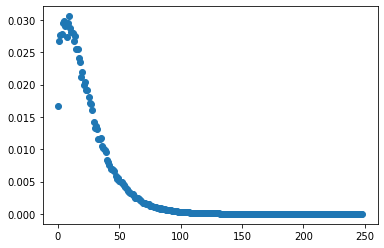

In [65]:
x_normal=np.mean(x[:-1,:-1],axis=0)
x_normal=x_normal/x_normal.max()
x_normal/=np.sum(x_normal)
plt.plot(x_normal,'o')
plt.show()

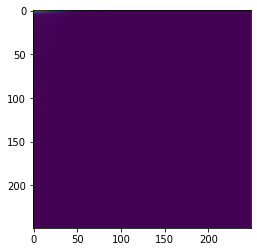

In [66]:
x_normal=np.mean(x[:-1,:-1])
x_normal=x[:-1,:-1]/x_normal.max()
x_normal/=np.sum(x_normal)
x_normal/=x_normal.max()
# x_normal = np.clip((x-x.mean())/x.std(),0,1)
plt.imshow(x_normal,cmap=plt.get_cmap('viridis'))
plt.show()

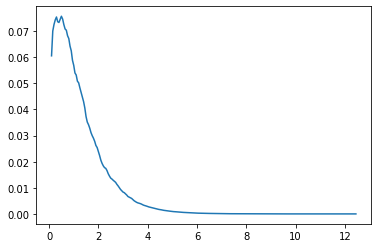

1556.25
12.5


In [68]:
n=3
dx=5e-5
NNr = len(co_rz_all[0,:,0])
x_data=np.array(range(NNr))*dx*1000
ret = np.cumsum(np.mean(x,axis=0), dtype=float)
ret[n:] = ret[n:] - ret[:-n]
ret=ret[n - 1:] / n
plt.plot(x_data[n-1:],ret/(NNr*dx*1000))
plt.savefig('co_z_linear.png')
plt.show()
print(np.sum(x_data))
print(NNr*dx*1000)

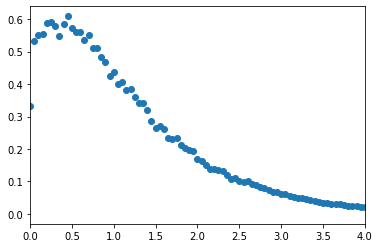

In [7]:
dx=5e-5

pz=np.sum(x[:-1,:-1],axis=0)
pz=pz/np.sum(pz)
x_data = np.array(list(range(len(pz))))
y=np.sum(co_rz_all,axis=0)
y[0,0]=0
y[NNr-1,NNr-1]=0
y=np.mean(y,axis=0)
y=y/np.sum(y)
y/=(dx*1000)
xs=np.array(range(len(y)))*(dx*1000)
plt.plot(xs,y,'o')
#plt.ylim([0,0.1])
plt.xlim([0,4])
plt.show()

In [9]:
xx=np.sum(co_rz_all+cross_rz_all)
xy=np.sum(co_rz_all)-np.sum(cross_rz_all)
a=np.sum(co_rz_all,axis=0)
a[0,0]=0
a=np.sum(a)
b=np.sum(incoh_cross_xy_all,axis=0)
where_are_NaNs = np.isnan(b)
b[where_are_NaNs] = 0
where_are_NaNs = np.isnan(b)
b=np.sum(b)
#b=np.abs(b)
print((a+b)/a/2)

0.5287724137306213


In [10]:
c=np.sum(co_xy_all,axis=0)
d=np.sum(incoh_cross_xy_all,axis=0)
print(np.sum(d))

2657968.8


In [11]:
l=1.465559
vv=1.453065
hv=1.553473
hp=2
oh=1.337506
vec=[l,vv,hv,hp,oh]
for el in vec:
    print(el/np.sum(vec))

0.1876611397531987
0.1860613145124022
0.19891830609059127
0.2560949641102115
0.17126427553359624


In [12]:
a1=np.sum(co_rz_all,axis=0)
a2=np.sum(a1[1:,1:])
#b1=~np.isnan(cross_xy_all)
b1=np.sum(incoh_cross_rz,axis=0)
b2=np.sum(b1[1:,1:])
sum=np.sum(a2+b2)
print(a1[0,0]/sum)

0.00018411619


In [69]:
import numpy as np 
import matplotlib.pyplot as plt

grid_size = NNr
i_all = np.sum(i_stokes_rz_all, axis=0)
q_all = np.sum(q_stokes_rz_all, axis=0)
u_all = np.sum(u_stokes_rz_all, axis=0)
v_all = np.sum(v_stokes_rz_all, axis=0)
q_z=np.sum(q_all[:,:-1], axis=0)
u_z=np.sum(u_all[:,:-1], axis=0)
v_z=np.sum(v_all[:,:-1], axis=0)
sum_quv=np.sqrt(np.power(q_z,2)+np.power(u_z,2)+np.power(v_z,2))
sum_quv[sum_quv==0]=1
q_z/=sum_quv
u_z/=sum_quv
v_z/=sum_quv


plt.plot(q_z[:-1],'o')
plt.plot(u_z[:-1],'o')
# plt.plot(v_z[:-1],'o')
# plt.legend(["q", "u",'v'])
plt.show()
print(np.unique(q_all))

NameError: name 'i_stokes_rz_all' is not defined

In [2]:
#SAVE
import numpy as np
import os

dx=4e-4
dr=dx
no=1.33
ne=1.33
chi=5.36e-5
SAVEDIR='data'
if not os.path.isdir(os.path.join(SAVEDIR)):
    os.mkdir(SAVEDIR)
vars=[     
co_xy_all ,
co_rz_all ,
co_rz_trad_all ,
incoh_cross_xy_all ,
incoh_cross_rz_all ,
cross_xy_all ,
cross_rz_all ,
i_stokes_rz_all ,
q_stokes_rz_all ,
u_stokes_rz_all ,
v_stokes_rz_all 
]
vars_names=[
'co_xy_all',
'co_rz_all',
'co_rz_trad_all',
'incoh_cross_xy_all',
'incoh_cross_rz_all',
'cross_xy_all',
'cross_rz_all',
'i_stokes_rz_all',
'q_stokes_rz_all',
'u_stokes_rz_all',
'v_stokes_rz_all'
]
for var, var_name in zip(vars,vars_names):
    np.save(os.path.join(SAVEDIR,var_name+'.npy'),var)

params=[NNxy,NNr,NNz,iters,dx,dr,dim,no,ne,]  
params_names=['NNxy','NNr','NNz','iters','dx','dr','dim','no','ne','chi']  
with open(os.path.join(SAVEDIR,'params.txt'),'w') as f:
    for param, param_name in zip(params, params_names):
        f.writelines(param_name+'='+str(param))


In [1]:
#LOAD Linear
import numpy as np
import os
LOADDIR='data'

gridDim = 4
blockDim = 128
dim = gridDim * blockDim
NNxy = 400
NNr = int(NNxy/2)
NNz = int(NNxy/2)

co_xy_all = np.zeros((dim, NNxy, NNxy), dtype=np.float32)
co_rz_all = np.zeros((dim, NNr, NNz), dtype=np.float32)
co_rz_trad_all = np.zeros((dim, NNr, NNz), dtype=np.float32)
incoh_cross_xy_all=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
incoh_cross_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
cross_xy_all=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
cross_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
i_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
q_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
u_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)
v_stokes_rz_all=np.zeros((dim, NNr, NNz), dtype=np.float32)

vars=[     
co_xy_all ,
co_rz_all ,
co_rz_trad_all ,
incoh_cross_xy_all ,
incoh_cross_rz_all ,
cross_xy_all ,
cross_rz_all ,
i_stokes_rz_all ,
q_stokes_rz_all ,
u_stokes_rz_all ,
v_stokes_rz_all ,
]
vars_names=[
'co_xy_all',
'co_rz_all',
'co_rz_trad_all',
'incoh_cross_xy_all',
'incoh_cross_rz_all',
'cross_xy_all',
'cross_rz_all',
'i_stokes_rz_all',
'q_stokes_rz_all',
'u_stokes_rz_all',
'v_stokes_rz_all'
]
for i, var_name in enumerate(vars_names):
    vars[i][:,:,:]=np.load(os.path.join(LOADDIR,var_name+'.npy'))

FileNotFoundError: [Errno 2] No such file or directory: 'data\\co_xy_all.npy'

In [1]:
import numpy as np
import os
#LOAD linear 
#linear address
LOADDIR='data/data8 linear'
dim=128
NNxy=500
NNr=250
NNz=NNr
vars_names=[
'co_xy_all',
'co_rz_all',
'incoh_cross_xy_all',
'incoh_cross_rz_all',
'cross_xy_all',
'cross_rz_all'
]
co_xy_linear = np.zeros((dim, NNxy, NNxy), dtype=np.float32)
co_rz_linear = np.zeros((dim, NNr, NNz), dtype=np.float32)
incoh_cross_xy_linear=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
incoh_cross_rz_linear=np.zeros((dim, NNr, NNz), dtype=np.float32)
cross_xy_linear=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
cross_rz_linear=np.zeros((dim, NNr, NNz), dtype=np.float32)
 
vars=[co_xy_linear,co_rz_linear,incoh_cross_xy_linear,incoh_cross_rz_linear,cross_xy_linear,cross_rz_linear]

for i, var_name in enumerate(vars_names):
    vars[i][:,:,:]=np.load(os.path.join(LOADDIR,var_name+'.npy'))

In [4]:
import numpy as np
import os
#LOAD  circular
#circular address
LOADDIR='data/data9 circ'
dim=128
NNxy=500
NNr=250
NNz=NNr
vars_names=[
'co_xy_all',
'co_rz_all',
'incoh_cross_xy_all',
'incoh_cross_rz_all',
'cross_xy_all',
'cross_rz_all'
]
co_xy_circ = np.zeros((dim, NNxy, NNxy), dtype=np.float32)
co_rz_circ = np.zeros((dim, NNr, NNz), dtype=np.float32)
incoh_cross_xy_circ=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
incoh_cross_rz_circ=np.zeros((dim, NNr, NNz), dtype=np.float32)
cross_xy_circ=np.zeros((dim, NNxy, NNxy), dtype=np.float32)
cross_rz_circ=np.zeros((dim, NNr, NNz), dtype=np.float32)
 
vars=[co_xy_circ,co_rz_circ,incoh_cross_xy_circ,incoh_cross_rz_circ,cross_xy_circ,cross_rz_circ]


for i, var_name in enumerate(vars_names):
    vars[i][:,:,:]=np.load(os.path.join(LOADDIR,var_name+'.npy'))

In [31]:
co_linear_sum_all=abs(np.sum(co_rz_linear))
incoh_cross_linear_sum_all=abs(np.sum(incoh_cross_rz_linear))
cross_linear_sum_all=abs(np.sum(cross_rz_linear))

co_circ_sum_all=abs(np.sum(co_rz_circ))
incoh_cross_circ_sum_all=abs(np.sum(incoh_cross_rz_circ))
cross_circ_sum_all=abs(np.sum(cross_rz_circ))


co_linear_sum=abs(np.sum(co_rz_linear[:,:-1,:-1]))
incoh_cross_linear_sum=abs(np.sum(incoh_cross_rz_linear[:,:-1,:-1]))
cross_linear_sum=abs(np.sum(cross_rz_linear[:,:-1,:-1]))

co_circ_sum=abs(np.sum(co_rz_circ[:,:-1,:-1]))
incoh_cross_circ_sum=abs(np.sum(incoh_cross_rz_circ[:,:-1,:-1]))
cross_circ_sum=abs(np.sum(cross_rz_circ[:,:-1,:-1]))


x=np.sum(co_rz_linear,axis=0)
x=x[:-1,:-1]
inchoh_sum=incoh_cross_linear_sum+incoh_cross_circ_sum
incoh_sum_all=incoh_cross_linear_sum_all+incoh_cross_linear_sum
sum_all = co_linear_sum_all+incoh_cross_linear_sum_all+cross_linear_sum_all+co_circ_sum_all+incoh_cross_circ_sum_all+cross_circ_sum_all
print(x.max()/inchoh_sum)

0.018864667


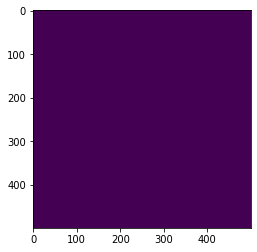

50907.76


In [32]:
import matplotlib.pyplot as plt

x=np.sum(co_xy_linear,axis=0)
y=np.sum(incoh_cross_xy_linear,axis=0)
x[0,0]=0
x[NNxy-1,NNxy-1]=0
y[0,0]=1e-3
y[NNxy-1,NNxy-1]=1e-3
y[y==0]=1e-3
# x/=x.max()
# x=(x-x.mean())/x.std()
x=np.clip(x,0,1)
plt.imshow(y)
plt.show()
print(np.max(x/y))

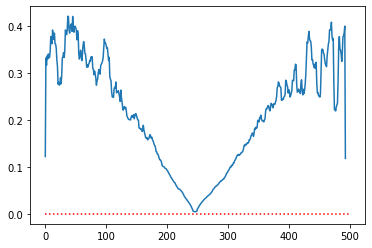

246


In [33]:
N=7

a=np.sum(x,axis=1)
b=np.sum(y,axis=1)
b[250]=b[251]
a=np.convolve(a, np.ones((N,))/N, mode='valid')
b=np.convolve(b, np.ones((N,))/N, mode='valid')
plt.plot(a/b)
# plt.ylim([-1,1])
plt.hlines(0,0,500,colors='red',linestyles='dotted')
plt.show()

print(np.argmax(b/a))

In [34]:
co_linear = np.mean(co_xy_linear,axis=0)
cross_linear=np.mean(cross_xy_linear,axis=0)
incoh_cross_linear=np.mean(incoh_cross_xy_linear,axis=0)

co_circ = np.mean(co_xy_circ,axis=0)
cross_circ=np.mean(cross_xy_circ,axis=0)
incoh_cross_circ=np.mean(incoh_cross_xy_circ,axis=0)

incoh_all = incoh_cross_linear+incoh_cross_circ
photons_all = co_linear+cross_linear+co_circ+cross_circ+incoh_all

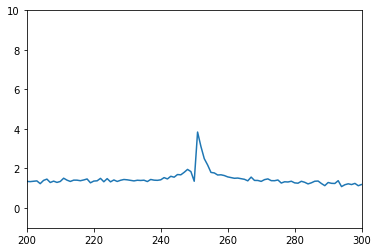

1299.7498


In [6]:
N=3
x=np.sum(co_linear,axis=0)
y=np.sum(incoh_all,axis=0)

# x=np.convolve(x, np.ones((N,))/N, mode='valid')
# y=np.convolve(y, np.ones((N,))/N, mode='valid')

p=x/y
plt.plot(p)
plt.xlim([200,300])
plt.ylim([-1,10])
plt.show()
print(np.max(p))

In [7]:
co_linear = np.mean(co_rz_linear,axis=0)
cross_linear=np.mean(cross_rz_linear,axis=0)
incoh_cross_linear=np.mean(incoh_cross_rz_linear,axis=0)

co_circ = np.mean(co_rz_circ,axis=0)
cross_circ=np.mean(cross_rz_circ,axis=0)
incoh_cross_circ=np.mean(incoh_cross_rz_circ,axis=0)

incoh_all = incoh_cross_linear+incoh_cross_circ
photons_all = co_linear+cross_linear+co_circ+cross_circ+incoh_all

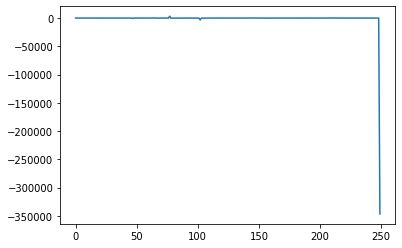

3228.3235
249


In [8]:
N=20
x=np.sum(co_circ,axis=0)
y=np.sum(cross_circ,axis=0)

# x=np.convolve(x, np.ones((N,))/N, mode='valid')
# y=np.convolve(y, np.ones((N,))/N, mode='valid')

p=(x/y)
plt.plot(p)
# plt.xlim([0,100])
# plt.ylim([-1,100])
plt.show()
print(np.max(p))
print(np.argmin(p))

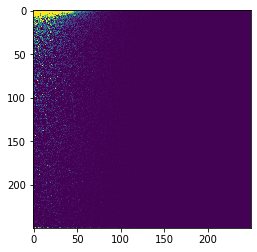

In [9]:
z=cross_linear
z=(z-z.mean()/z.std())
z=np.clip(z,0,1)
plt.imshow(z)
plt.show()


In [10]:
s=np.sum(incoh_cross_linear[1:,1:])
s/512/100

0.3376451873779297

In [ ]:
sum=0.936+0.610+0.562+0.05+0.01
0.05/sum

In [21]:
co_lin_s=np.sum(co_xy_linear[1:,1:])
cross_lin_s=np.sum(cross_xy_linear[1:,1:])
incoh_lin_s=np.sum(incoh_cross_xy_linear[1:,1:])

co_circ_s=np.sum(co_xy_circ[1:,1:])
cross_circ_s=np.sum(cross_xy_circ[1:,1:])
incoh_circ_s=np.sum(incoh_cross_xy_circ[1:,1:])

a=co_lin_s
b=abs(cross_lin_s)

c=co_circ_s
d=cross_circ_s

incoh_s=incoh_lin_s+incoh_circ_s
all=a+abs(b)+c+d+incoh_s

In [22]:
ratios=[a,b,c,d,incoh_s]
for ratio in ratios:
    print(ratio/all)

0.28365
0.0025770178
0.25916725
0.02247484
0.43213087


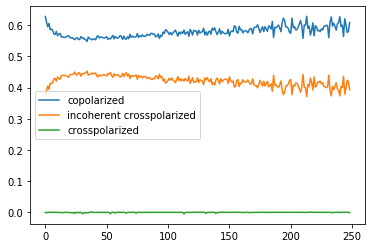

In [3]:
import matplotlib.pyplot as plt

co_rz_mean=np.mean(co_rz_linear,axis=0)
incoh_cross_rz_mean=np.mean(incoh_cross_rz_linear,axis=0)
cross_rz_mean=np.mean(cross_rz_linear,axis=0)

co_z_linear = np.mean(co_rz_mean,axis=0)
incoh_cross_z_linear=np.mean(incoh_cross_rz_mean,axis=0)
cross_z_linear=np.mean(cross_rz_mean,axis=0)

sum = np.power(co_z_linear,1)+np.power(incoh_cross_z_linear,1)+cross_z_linear
plt.plot(co_z_linear[:-1]/sum[:-1])
plt.plot(incoh_cross_z_linear[:-1]/sum[:-1])
plt.plot(cross_z_linear[:-1]/sum[:-1])
plt.legend(['copolarized','incoherent crosspolarized', 'crosspolarized'])
plt.savefig('opaccovscrossvsincohlinear.png')
plt.show()

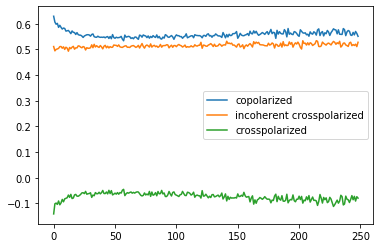

In [5]:
import numpy as np
import matplotlib.pyplot as plt

co_rz_mean=np.mean(co_rz_circ,axis=0)
incoh_cross_rz_mean=np.mean(incoh_cross_rz_circ,axis=0)
cross_rz_mean=np.mean(cross_rz_circ,axis=0)

co_z_circ = np.mean(co_rz_mean,axis=0)
incoh_cross_z_circ=np.mean(incoh_cross_rz_mean,axis=0)
cross_z_circ=np.mean(cross_rz_mean,axis=0)

sum = co_z_circ+incoh_cross_z_circ+cross_z_circ
plt.plot(co_z_circ[:-1]/sum[:-1])
plt.plot(incoh_cross_z_circ[:-1]/sum[:-1])
plt.plot(cross_z_circ[:-1]/sum[:-1])
plt.legend(['copolarized','incoherent crosspolarized', 'crosspolarized'])
plt.savefig('opaccirccovscrossvsincohcirc.png')
plt.show()

In [23]:
incoh_cross_rz_circ



array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.